# `--- Day 11: Hex Ed ---`

# Coordinate system
I didn't have a seat on the train at first, so I started out with paper and pencil working out what coordinate system I would use:-

![working](working.jpg)

Initially, I was thinking I'd create a `networkx` graph of the path plus all hexagons at the same distance from the origin as the current hex (hence the comment about the using the same algorithm as the spiral, i.e. Day 3) and use BFS to find the shortest path, but then realised that it's actually just a hexagonal version of the Manhattan distance.

Essentially, from the final position, $(x, y)$, we take steps in whichever diagonal directional is towards the origin.  i.e. if

$$x > 0, y > 0 \rightarrow SW$$
$$x > 0, y < 0 \rightarrow NW$$
$$x < 0, y < 0 \rightarrow NE$$
$$x < 0, y > 0 \rightarrow SE$$

Moving in this direction a number steps, $S_1$, equal to

$$S_1 = \min ( \lvert x \rvert, \lvert y \rvert )$$

takes us to either the $x$ or $y$ axis.

From the axis, the remaining number of steps, $S_2$, depends on whether we hit the $x$ or the $y$ axis.

$$S_2 = ( \lvert y \rvert - S_1 ) / 2 + ( \lvert x \rvert - S_1 )$$

N.B. one or other of the terms in the expression for $S_2$ will always be zero.  The total step distance is then, 

$$S = S_1 + S_2$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_walk = pd.read_csv('input.txt', header=None).T
raw_walk.columns = ['dir']

In [3]:
move = {'n': (0, 2),
        'nw': (-1, 1),
        'sw': (-1, -1),
        's': (0, -2),
        'se': (1, -1),
        'ne': (1, 1)}

In [4]:
start_x = start_y = 0
start = pd.DataFrame([['<start>', start_x, start_y]], columns=['dir', 'x', 'y'])

In [5]:
def do_walk(start, raw_walk):
    subprogram_walk = raw_walk.copy()
    # map 'n', 'ne', etc. moves to vectors
    subprogram_walk['x'] = subprogram_walk['dir'].apply(lambda x: move[x][0])
    subprogram_walk['y'] = subprogram_walk['dir'].apply(lambda x: move[x][1])
    # add in the start position
    subprogram_walk = pd.concat([start, subprogram_walk]).reset_index(drop=True)
    finish = subprogram_walk.sum()
    finish.dir = '<finish>'
    #
    subprogram_walk['pathx'] = subprogram_walk['x'].cumsum()
    subprogram_walk['pathy'] = subprogram_walk['y'].cumsum()
    return subprogram_walk

In [6]:
def step_dist(a, b):
    '''a and b are (x,y) coord pairs of hexagon centres'''
    a_x, a_y, b_x, b_y = *a, *b
    delta_x = a_x - b_x
    delta_y = a_y - b_y
    # distance to nearest axis, moving in ne,nw,se,sw steps
    steps = min(map(abs, (delta_x, delta_y)))
    # remaining distance
    remaining_delta = abs(delta_x) - abs(delta_y)
    if remaining_delta > 0:
        # we hit the x-axis first therefore remaining steps are equal to the remaining delta
        steps += remaining_delta
    elif remaining_delta < 0:
        steps += -remaining_delta/2
    else:
        # we already hit the origin
        pass
    return int(steps)

In [7]:
def walk(start, raw_walk):
    subprogram_walk = do_walk(start, raw_walk)
    subprogram_walk['step_dist'] = subprogram_walk.apply(lambda p: step_dist((start_x, start_y),
                                                                             (p['pathx'], p['pathy'])),
                                                         axis=1)

    p1 = subprogram_walk.tail(1).step_dist.values[0]
    p2 = subprogram_walk.step_dist.max()
    return p1, p2, subprogram_walk

# Part 1/Part 2

In [8]:
p1, p2, subprogram_walk = walk(start, raw_walk)
print(f'part 1 answer: {p1}\npart 2 answer: {p2}')

part 1 answer: 720
part 2 answer: 1485


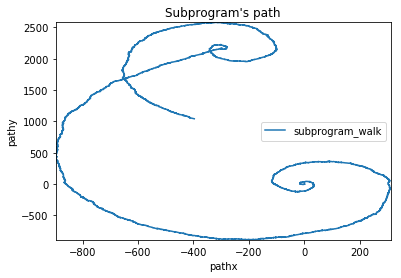

In [9]:
ax = subprogram_walk.plot(x='pathx', y='pathy', label='subprogram_walk', title='Subprogram\'s path')
ax.set_xlim(subprogram_walk.pathx.min(), subprogram_walk.pathx.max())
ax.set_ylim(subprogram_walk.pathy.min(), subprogram_walk.pathy.max())
ax.set_ylabel('pathy')
plt.savefig('subprogram_path.png')

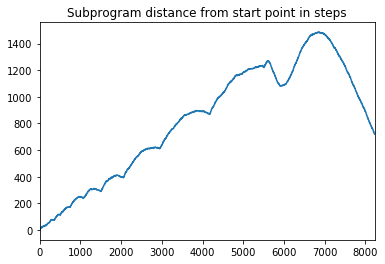

In [10]:
subprogram_walk.step_dist.plot(title='Subprogram distance from start point in steps')

# Examples


    ne,ne,ne is 3 steps away.
    ne,ne,sw,sw is 0 steps away (back where you started).
    ne,ne,s,s is 2 steps away (se,se).
    se,sw,se,sw,sw is 3 steps away (s,s,sw).


In [11]:
from io import StringIO
from matplotlib.path import Path
import matplotlib.patches as patches

def raw_walk_from_string(s):
    fd = StringIO(s)
    raw_walk = pd.read_csv(fd, header=None).T
    raw_walk.columns = ['dir']
    return raw_walk

In [12]:
third = 1/3
vertices = [(third, 1),
            (2*third, 0),
            (third, -1),
            (-third, -1),
            (-2*third, 0),
            (-third, 1),
            (third, 1)]
codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY]

def draw_hex(x, y, ax):
    verts = np.add(vertices, (x, y))
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='orange', alpha=0.4, lw=2)
    ax.add_patch(patch)
    return ax

def do_example(s):
    raw_walk = raw_walk_from_string(s)
    p1, p2, subprogram_walk = walk(start, raw_walk)
    print(f'path: {s}\npart 1 answer: {p1}\npart 2 answer: {p2}')
    ax = subprogram_walk.plot(x='pathx', y='pathy', label='subprogram_walk', title='Subprogram\'s path')
    subprogram_walk.plot(kind='scatter', x='pathx', y='pathy', s=100,
                         color='green', ax=ax)
    subprogram_walk[['pathx', 'pathy']].drop_duplicates().apply(lambda p: draw_hex(p['pathx'], p['pathy'],
                                                                                   ax), axis=1)
    ax.set_xlim(subprogram_walk.pathx.min() - 1, subprogram_walk.pathx.max() + 1)
    ax.set_ylim(subprogram_walk.pathy.min() - 2, subprogram_walk.pathy.max() + 2)
    return ax

path: ne,ne,ne
part 1 answer: 3
part 2 answer: 3


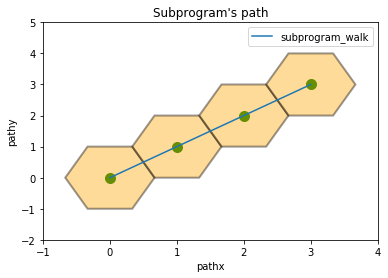

In [13]:
do_example('ne,ne,ne')

path: ne,ne,sw,sw
part 1 answer: 0
part 2 answer: 2


C:\Users\oakden\Anaconda2\envs\dspython362\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


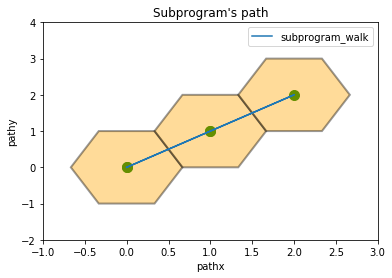

In [14]:
do_example('ne,ne,sw,sw')

path: ne,ne,s,s
part 1 answer: 2
part 2 answer: 2


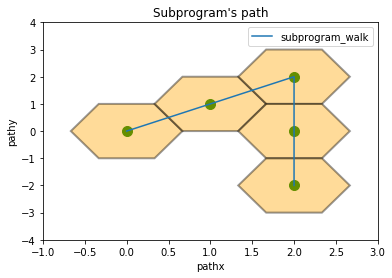

In [15]:
do_example('ne,ne,s,s')

path: se,sw,se,sw,sw
part 1 answer: 3
part 2 answer: 3


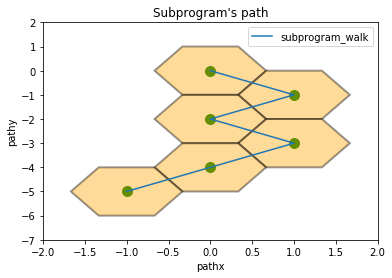

In [16]:
do_example('se,sw,se,sw,sw')

path: ne,se,ne,se,ne,se
part 1 answer: 6
part 2 answer: 6


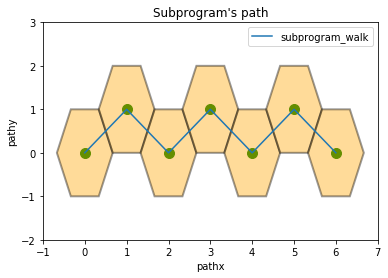

In [17]:
# extra example from reddit, showing that my distance algorithm is correct
do_example('ne,se,ne,se,ne,se')